In [2]:

pip install 'scanpy[leiden]'

Note: you may need to restart the kernel to use updated packages.


In [3]:
import anndata as ad
import pandas as pd
import scanpy as sc
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [4]:
with open("/Users/junequ/Downloads/sc-RNA/data/expr_matrix.csv") as your_data:
    adata = ad.read_csv(your_data, delimiter=',')

adata.write_h5ad("/Users/junequ/Downloads/sc-RNA/data/expr.h5ad")

# view cell metadata
print(adata.obs.head())
# view gene metadata
print(adata.var.head())

/opt/anaconda3/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)


Empty DataFrame
Columns: []
Index: [GSM1658192, GSM1658245, GSM1658167, GSM1658117, GSM1658352]
Empty DataFrame
Columns: []
Index: [1/2-SBSRNA4 , A1BG , A1BG-AS1 , A1CF , A2LD1 ]


In [5]:
# 1) Read both metadata CSVs and set GSM as the index
df_meta  = pd.read_csv("/Users/junequ/Downloads/sc-RNA/data/celltype_df.csv") 
df_meta2 = pd.read_csv("/Users/junequ/Downloads/sc-RNA/data/celltype_2_df.csv")

df_meta  = df_meta.set_index("GSM")   # must have a “cell_type” column
df_meta2 = df_meta2.set_index("GSM")  # must also have a “cell_type” column

# 2) Re‐index each to match exactly adata.obs_names
series1 = df_meta.reindex(adata.obs_names)["cell_type"]
series2 = df_meta2.reindex(adata.obs_names)["cell_type"]

# 3) Combine them, preferring series1 whenever it’s not NaN, otherwise taking series2
#    You can do this with pandas.combine_first:
combined = series1.combine_first(series2)

#    (Alternatively, you could write:)
#    combined = series1.copy()
#    combined[combined.isna()] = series2[combined.isna()]

# 4) Assign the combined series into adata.obs
adata.obs["cell_type"] = combined.astype("category")

# 5) Verify
print(adata.obs.head())



                   cell_type
GSM1658192           neurons
GSM1658245   fetal_quiescent
GSM1658167  oligodendrocytes
GSM1658117       endothelial
GSM1658352   fetal_quiescent


In [6]:
# filter and normalize data
sc.pp.filter_genes(adata, min_cells=100)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [7]:
# dimension reduction steps
# Highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
adata = adata[:, adata.var.highly_variable]     

# PCA
sc.pp.scale(adata, max_value=10)                 
sc.tl.pca(adata, svd_solver="arpack")

# k-NN graph for UMAP
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40) 


/opt/anaconda3/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


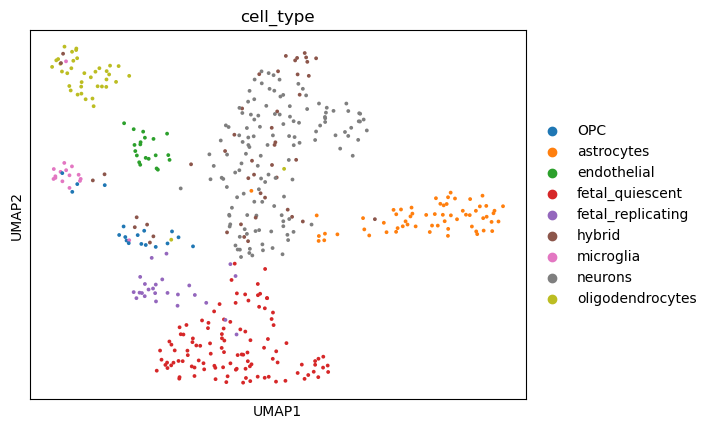

,cell_type
GSM1658192,neurons
GSM1658245,fetal_quiescent
GSM1658167,oligodendrocytes
GSM1658117,endothelial
GSM1658352,fetal_quiescent
...,...
GSM1657928,OPC
GSM1658188,microglia
GSM1658357,fetal_quiescent
GSM1658068,astrocytes


In [8]:
# plot by colored cell types
sc.tl.umap(adata)  
sc.pl.umap(adata, color="cell_type", size=30)

adata.obs


In [9]:
# label all astrocytes as 1
def label(x):
    if x == "astrocytes":
        return 1
    else:
        return 0

In [10]:
# give all cell types as label 1 if is astrocyte
y = adata.obs.cell_type.map(label)
print(y)

GSM1658192    0
GSM1658245    0
GSM1658167    0
GSM1658117    0
GSM1658352    0
             ..
GSM1657928    0
GSM1658188    0
GSM1658357    0
GSM1658068    1
GSM1658051    1
Name: cell_type, Length: 466, dtype: int64


In [11]:
sel = RandomForestClassifier(n_jobs=5, n_estimators=100)
sel.fit(adata.X, y)


RandomForestClassifier(n_jobs=5)

In [12]:
sel.feature_importances_
adata.var_names

Index(['A2M ', 'AADAT ', 'AAGAB ', 'AAK1 ', 'AAMP ', 'AARS ', 'AASS ',
       'ABCA1 ', 'ABCA3 ', 'ABCB7 ',
       ...
       'ZNF841 ', 'ZNF91 ', 'ZNF92 ', 'ZNFX1 ', 'ZRANB1 ', 'ZRANB2 ', 'ZUFSP ',
       'ZXDC ', 'no_feature ', 'alignment_not_unique '],
      dtype='object', length=3000)

In [13]:
# associate gene names with feature importance scores
pd.DataFrame(sel.feature_importances_, index=adata.var_names).sort_values(0, ascending=False)

,0
SLC1A2,0.045266
AGXT2L1,0.039371
GJA1,0.022300
AGT,0.021703
SLC1A3,0.021519
...,...
KIAA1432,0.000000
KIAA1456,0.000000
KIAA1524,0.000000
KIAA1549,0.000000


False


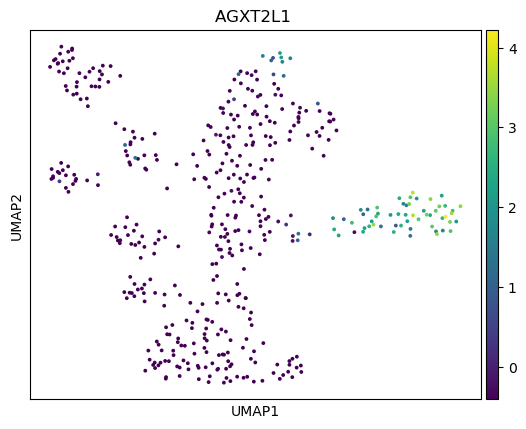

In [14]:
# check that the most important gene that differentiates astrocytes from the rest of the cells is in variable names
print("AGXT2L1" in adata.var_names) 

# color by a specified gene to visualize cell clusters
sc.pl.umap(adata, color="AGXT2L1 ", size=30)

In [15]:
# 78 cells
count = len(adata[adata.obs.cell_type.isin(['astrocytes', 'microglia'])])

# check the amount of cells that are not astrocytes or microglia
adata[~adata.obs.cell_type.isin(['astrocytes', 'microglia'])]

View of AnnData object with n_obs × n_vars = 388 × 3000
    obs: 'cell_type'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [16]:
import random
num = len(random.choices(adata[~adata.obs.cell_type.isin(['astrocytes', 'microglia'])].obs.index, k = count))
barcode = random.choices(adata[~adata.obs.cell_type.isin(['astrocytes', 'microglia'])].obs.index, k = count)
num

78

In [17]:
# concatenating different cell groups into the same list
barcodes = barcode + adata[adata.obs.cell_type.isin(['astrocytes', 'microglia'])].obs.index.tolist()
len(barcodes)


156

In [18]:
# define training dataset by subsetting adata by the barcodes
train = adata[barcodes]
train


View of AnnData object with n_obs × n_vars = 156 × 3000
    obs: 'cell_type'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
# test dataset
adata_test = sc.read_h5ad("/Users/junequ/Downloads/sc-RNA/db3a3799-3c3f-44db-96a5-81da79a5f3e3.h5ad")

KeyboardInterrupt: 

In [30]:
adata_test.obs["cell_type"]

GCGACCATCCCTAACC_SC22                       alveolar macrophage
P2_1_GCGCAACCAGTTAACC                       natural killer cell
GCTCTGTAGTGCTGCC_SC27            pulmonary alveolar type 2 cell
P2_8_TTAGGACGTTCAGGCC                       alveolar macrophage
CTTGATTGTCAGTTTG_T164                    respiratory basal cell
                                           ...                 
ACCTTTACATTAACCG_T120                    respiratory basal cell
CATTATCTCCATGAAC_F01639    CD1c-positive myeloid dendritic cell
AGGCCGTGTGTGACCC-SC56            pulmonary alveolar type 2 cell
CGATGGCAGCAGGCTA-1-2                                  club cell
AATCGGTGTCGGCACT-1-4                                  club cell
Name: cell_type, Length: 584944, dtype: category
Categories (50, object): ['hematopoietic stem cell', 'fibroblast', 'mesothelial cell', 'T cell', ..., 'bronchus fibroblast of lung', 'alveolar type 1 fibroblast cell', 'alveolar adventitial fibroblast', 'respiratory tract hillock cell']

In [28]:
if 'cell_type' in adata_test:
    print(adata_test['cell_type'].value_counts())

AttributeError: AnnData has no attribute __contains__, don’t check `in adata`.

In [ ]:
if 'cell_type' in adata.obs:
    print(adata.obs['cell_type'].value_counts())

In [25]:
# compare target and train dataset's gene pool
common_genes = set(adata.var_names) & set(adata_test.var_names)
# print(adata.var_names)
print(adata_test.var_names)
print(len(common_genes))  # Should be close to original (~20k genes)


Index(['ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084',
       'ENSG00000001167',
       ...
       'ENSG00000283052', 'ENSG00000283063', 'ENSG00000283064',
       'ENSG00000283071', 'ENSG00000283075', 'ENSG00000283078',
       'ENSG00000283103', 'ENSG00000283117', 'ENSG00000283118',
       'ENSG00000283125'],
      dtype='object', length=27957)
0


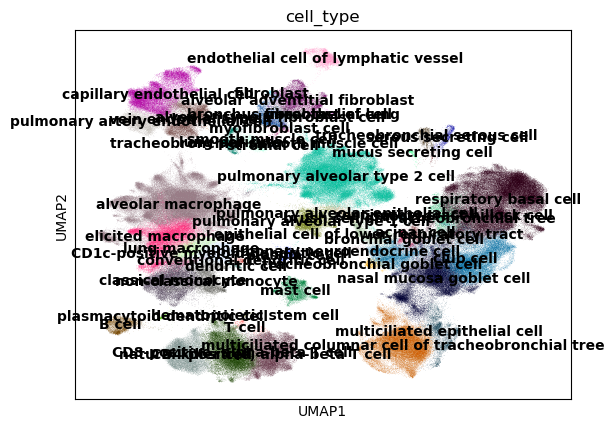

In [31]:
if 'X_umap' in adata_test.obsm:
    sc.pl.umap(adata_test, color='cell_type', legend_loc='on data')

SyntaxError: invalid decimal literal (2707160156.py, line 1)